# Merge of IGN and Bugianen, Mont-blanc area

* French side: IGNt5-MontBlanc-Chambery-Evian 
* Italian side: Bugianen - Monte Bianco

This is similar (and anterior to) frit3 and frit4, but wih specificities because french map is better in this area.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS


In [3]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = GY.bbalp_names

### The plan for each zoom-level is as follows

* z<=11: IGN everywhere (no Bugianen, and we usually display SwissTopo on top)
* z12, it, ch: keep IGN: missing some huts but much more information overall (anyway still swisstopo available at z12 for montebianco only)
* z13, it, ch: keep Bugianen: IGN is clearer but missing a lot of rivers, and hut/summit/place place names
* ... but at z15 & z16, IGN uses an old scanned topo map which is quite ok, north of Col du Petit-Saint-Bernard 45.67, 6.9.
This could be kept, at the cost of removing partially white tiles, or filling them with `mbt_partial.fill_partial_data`

INFO:shapely.geos:Self-intersection at or near point 10.54688 47.517200000000003


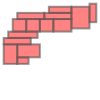

In [4]:
GY.alps2geojson('../data/areas/etopo_alps_extents.geojson')
GY.MultiPolygon(map(GY.bb2poly, GY.bbalps.values()))

In [7]:
fritN = 5
workdir = f'frit{fritN}'
os.makedirs(workdir, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr = pjoin(workdir, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr)

'zoom = 9 16 ; n = 62043 * 18 kb/tile q = 75 ; bounds = 5.625,45.583,7.732,46.559 ; format = jpg ; name = IGNt5-MontBlanc-Chambery-Evian'

In [6]:
# this map contains z9-11 of enlarged Metropolitan France (-5 42.3 8.6 51.1)
mbtwalpsz9 = pjoin(realpath('../../mapdata/mobac_atlases'), 'IGN-fr-z9-12.mbtiles')
#also 'IGN-walps-z9-10.mbtiles'
M.mbt_info(mbtwalpsz9)

'zoom = 9 12 ; n = 27429 ; bounds = 6.32812,43.58039,8.4375,44.59047 ; center = 7.38281,44.08543,9 ; format = jpg ; name = IGN France baselayer z9-12'

In [7]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen'

In [8]:
bbfr = M.real_bounds(mbtfr)
bballit = M.real_bounds(mbtitall)
print("bbfr", bbfr)
bbitcut = bbfr._replace(east=bballit.east)

if fritN == 4:
    bbitcut = bbfr._replace(east=7.91)  # special case remove "Biella" area to make it more squareish
if fritN == 5:
    bbitcut = GY.bbalps5 # bbfr._replace(east=GY.lng9_sanremo_zermatt)  # force stop


print("bbcutit", bbitcut)
mbtitcut = pjoin(workdir, "itcutN.mbtiles")
! rm -f $mbtitcut
M.cut_to_lnglat(mbtitall, mbtitcut, bbitcut) #, zmin=14)

# it's tricky to not get extra tiles, see `epsilon` in cut_to_lng_lat

bbfr LngLatBbox(west=5.625000000000014, south=45.58328975600631, east=7.73437500000001, north=46.55886030311717)
bbcutit LngLatBbox(west=5.625000000000014, south=45.58328975600631, east=7.73437, north=46.55886030311717)
LngLatBbox(west=5.625, south=45.58329, east=7.73437, north=46.55886)
12 16 16
12 2123 <> 2135 2632 <> 2646
z 12 : added 75
13 4246 <> 4271 5264 <> 5293
z 13 : added 300
14 8492 <> 8543 10528 <> 10587
z 14 : added 1200
15 16984 <> 17087 21056 <> 21175
z 15 : added 4800
16 33968 <> 34175 42112 <> 42351
z 16 : added 19200
real bounds: LngLatBbox(west=6.679687499999985, south=45.58328975600631, east=7.734375000000008, north=46.012223840632366)


In [11]:
bbfrit = bbfr._replace(east=M.real_bounds(mbtitcut).east)
bbfrit

LngLatBbox(west=5.625000000000014, south=45.58328975600631, east=7.734375000000008, north=46.55886030311717)

In [20]:
# fill up the gaps at lower zoom levels

mbtbasemap = pjoin(workdir, 'basemap.mbtiles')
!rm -f $mbtbasemap
M.cut_to_lnglat(mbtwalpsz9, mbtbasemap, bbfrit)
mbtbasemapclean, reasons = MP.clean_missing_data(mbtbasemap, w=0.1, T=192)
reasons

9 12 12
9 264 <> 266 329 <> 330
z 9 : added 6
10 528 <> 533 658 <> 661
z 10 : added 24
11 1056 <> 1067 1316 <> 1323
z 11 : added 96
12 2112 <> 2135 2632 <> 2647
z 12 : added 384
real bounds: LngLatBbox(west=5.625000000000014, south=45.58328975600631, east=7.73437500000001, north=46.55886030311717)
Meta update {'bounds': '5.625,45.58329,7.73438,46.55886',
 'center': '6.67969,46.07108,9',
 'type': 'baselayer'}
Deleted 0. Status: 0 / 510
Deleted 0. Status: done!


defaultdict(int, {'': 510})

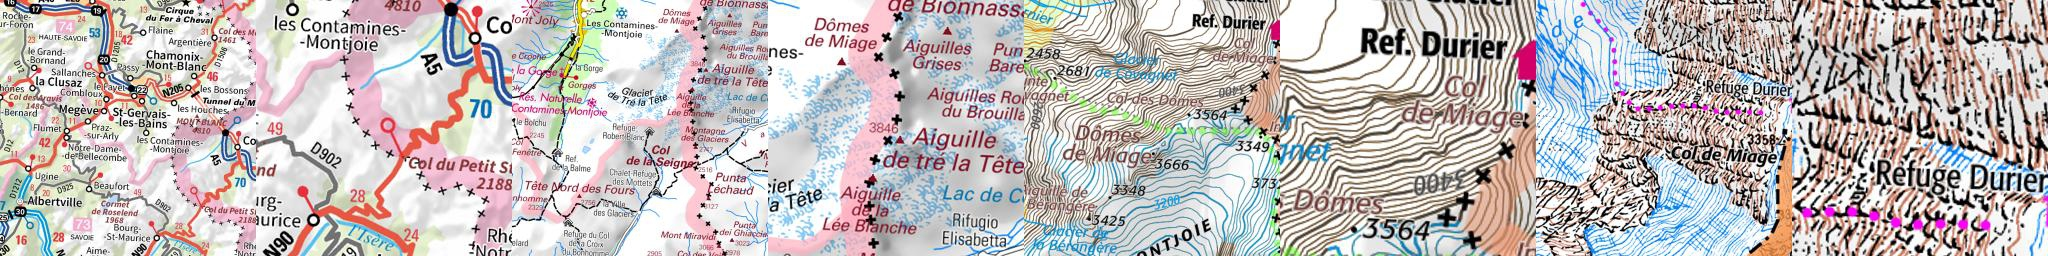

In [20]:
MY.tile_pyramid('miage_fr.jpg', ll=bbox.llmiage, mbt=mbtfr)
# MY.tile_pyramid('tignes_mch.jpg', ll=bbox.lltignes, mbt='mch.mbtiles')
Image('miage_fr.jpg')

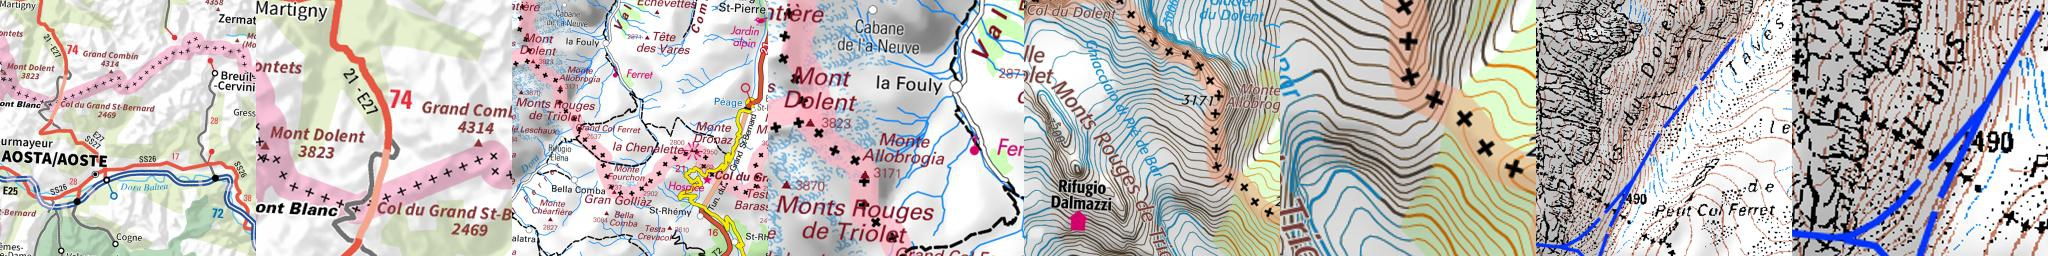

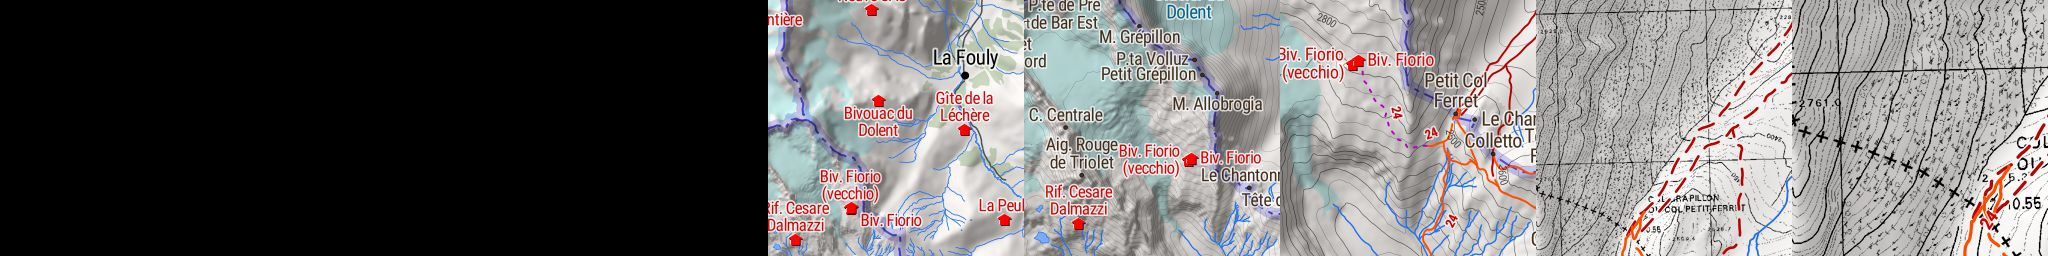

In [21]:
MY.tile_pyramid('ferret_fr.jpg', ll=bbox.llferret, mbt=mbtfr)
display(Image('ferret_fr.jpg'))
MY.tile_pyramid('ferret_it.jpg', ll=bbox.llferret, mbt=mbtitall)
display(Image('ferret_it.jpg'))

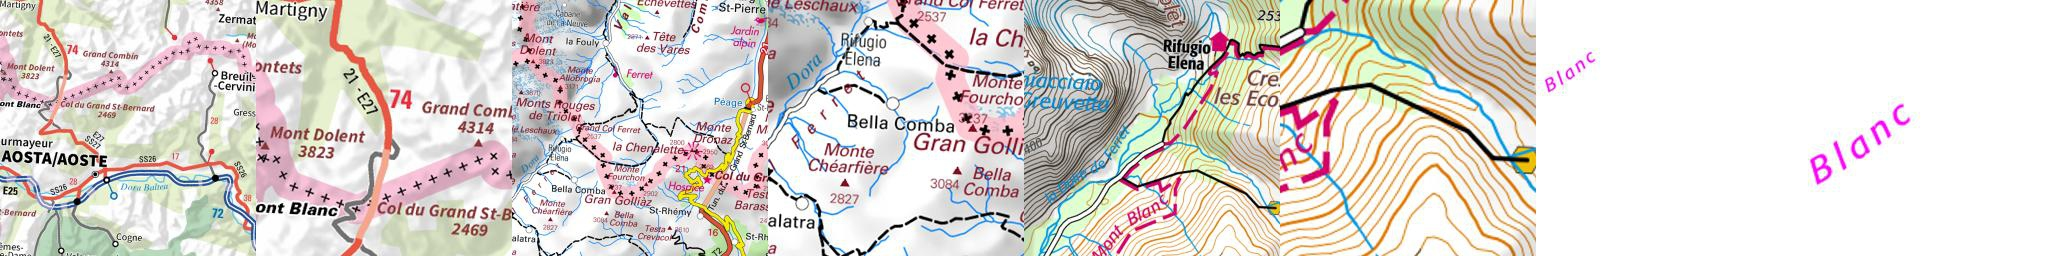

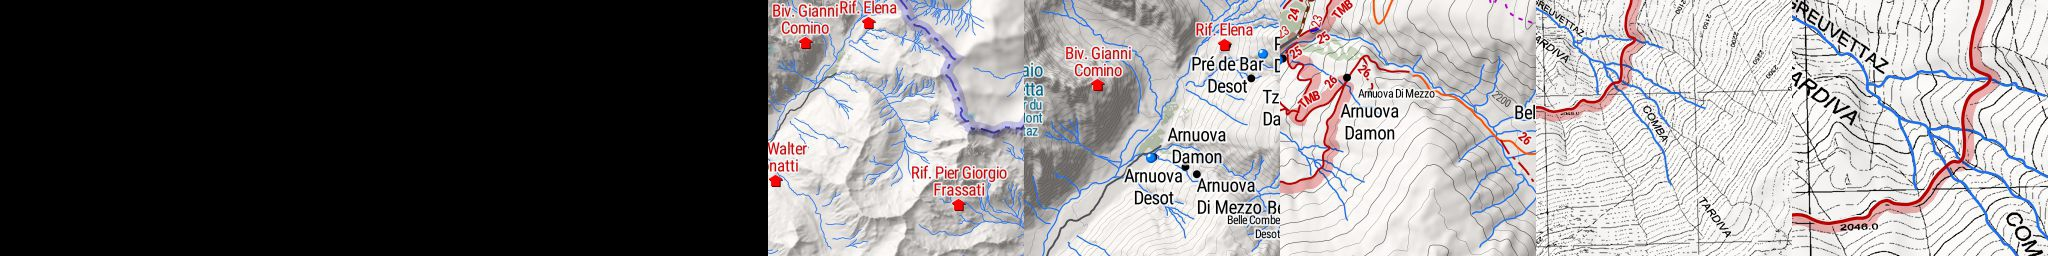

In [22]:
ferretblanc = T.LngLat(7.055, 45.865)
s = 'ferretblanc'
MY.tile_pyramid(s+'_fr.jpg', ll=ferretblanc, mbt=mbtfr)
display(Image(s+'_fr.jpg'))
MY.tile_pyramid(s+'_it.jpg', ll=ferretblanc, mbt=mbtitall)
display(Image(s+'_it.jpg'))

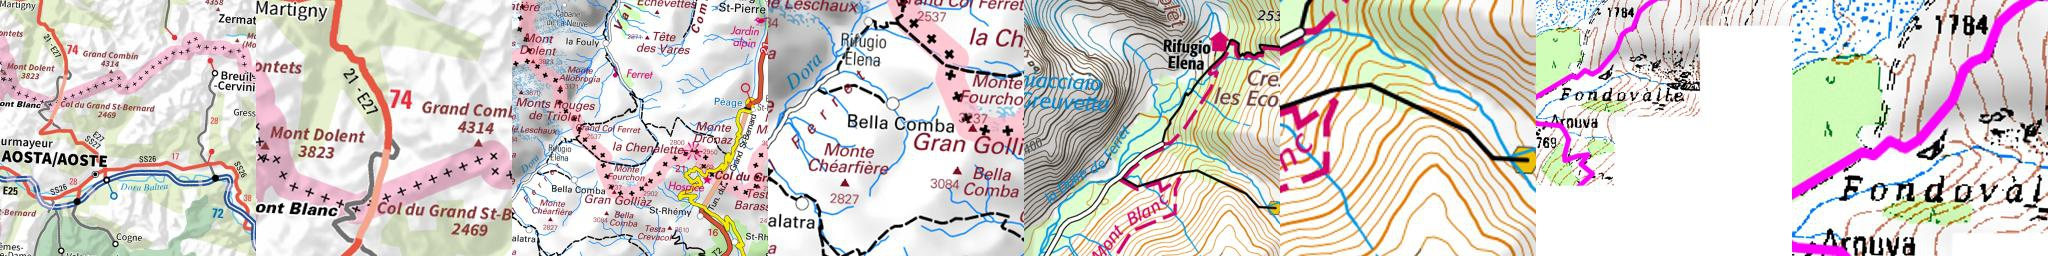

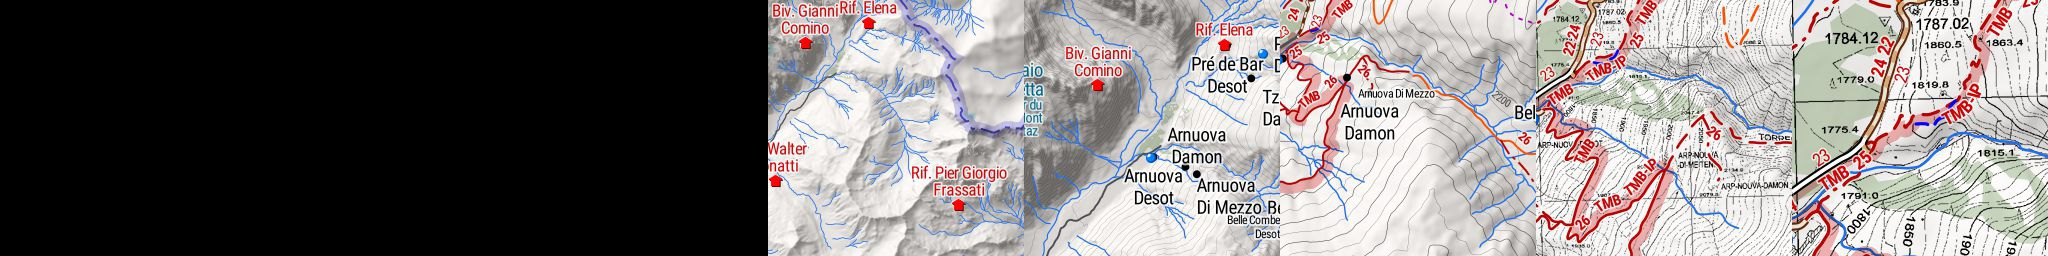

In [23]:
ferretblanc = T.LngLat(7.057, 45.871)
s = 'ferretcorner'
MY.tile_pyramid(s+'_fr.jpg', ll=ferretblanc, mbt=mbtfr)
display(Image(s+'_fr.jpg'))
MY.tile_pyramid(s+'_it.jpg', ll=ferretblanc, mbt=mbtitall)
display(Image(s+'_it.jpg'))

## Common to all zoom levels

Attempt to remove white tiles
becuse IGN tiles can have a lot of white esp. in flat areas (Geneva) we raise the requirement of partial tile to 30% white and 192 contiguous white pixels (75% of a side)

In [ ]:
mbtfrclean, stats = MP.clean_missing_data(mbtfr, w=0.1, T=255)
#mbtfrclean = 'frit5/clean_1672011103IGNt5-MontBlanc-Chambery-Evian.mbtiles'
mbtfrclean, stats

Deleted 0. Status: 0 / 62043
Deleted 48. Status: 2000 / 62043
Deleted 36. Status: 4000 / 62043
Deleted 142. Status: 6000 / 62043
Deleted 0. Status: 8000 / 62043
Deleted 0. Status: 10000 / 62043
Deleted 0. Status: 12000 / 62043
Deleted 237. Status: 14000 / 62043
Deleted 1260. Status: 16000 / 62043
Deleted 0. Status: 18000 / 62043
Deleted 0. Status: 20000 / 62043
Deleted 5. Status: 22000 / 62043
Deleted 3. Status: 24000 / 62043
Deleted 0. Status: 26000 / 62043
Deleted 1. Status: 28000 / 62043
Deleted 0. Status: 30000 / 62043
Deleted 3. Status: 32000 / 62043
Deleted 0. Status: 34000 / 62043
Deleted 2. Status: 36000 / 62043
Deleted 0. Status: 38000 / 62043
Deleted 0. Status: 40000 / 62043
Deleted 0. Status: 42000 / 62043
Deleted 0. Status: 44000 / 62043
Deleted 2. Status: 46000 / 62043
Deleted 0. Status: 48000 / 62043
Deleted 0. Status: 50000 / 62043
Deleted 0. Status: 52000 / 62043
Deleted 361. Status: 54000 / 62043
Deleted 779. Status: 56000 / 62043
Deleted 894. Status: 58000 / 62043
Del

('frit5/clean_1673208500IGNt5-MontBlanc-Chambery-Evian.mbtiles',
 defaultdict(int,
             {'': 55378, 'partial': 571, 'white': 6085, 'black&white': 9}))

## Geometry!

In [39]:
def load_first_feature(path):
    # We could use GeometryCollection if there's > 1
    with open(path) as f:
        root = json.load(f)
        if "features" in root:
            assert len(root["features"]) == 1
            root = root["features"][0]
        # NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates
        return shape(root["geometry"]).buffer(0)

In [40]:
def biggest_poly(multipoly):
    return multipoly.geoms[max((g.area, i) for i, g in enumerate(multipoly.geoms))[1]]

In [ ]:
def bb2poly(bb: T.LngLatBbox):
    return Polygon([
        Point(bb.west, bb.north),
        Point(bb.west, bb.south),
        Point(bb.east, bb.south),
        Point(bb.east, bb.north),
        Point(bb.west, bb.north)
    ])

In [ ]:
# def bounds2poly(bounds_tuple):
#     west, north, east, south = bounds_tuple
#     return Polygon([
#         Point(west, north),
#         Point(west, south),
#         Point(east, south),
#         Point(east, north),
#         Point(west, north)
#     ])

In [31]:
walps = load_first_feature('/home/me/mapproj/topo-fr-it/camargue-macon-sanremo-tile.geojson').buffer(0.007)
str(walps)

'POLYGON ((5 43.493, 4.999313880017693 43.493033706913295, 4.998634367745887 43.493134503037176, 4.997968007259219 43.493301417649874, 4.997321215973445 43.49353284327242, 4.996700222842218 43.49382655114956, 4.996111008368863 43.49417971271388, 4.9955592470108545 43.49458892682646, 4.995050252531694 43.49505025253169, 4.994588926826461 43.49555924701085, 4.9941797127138825 43.496111008368864, 4.993826551149562 43.496700222842215, 4.993532843272421 43.49732121597344, 4.9933014176498745 43.49796800725922, 4.993134503037178 43.498634367745886, 4.993033706913295 43.499313880017695, 4.993 43.5, 4.993 46.5, 4.993033706913295 46.500686119982305, 4.993134503037178 46.501365632254114, 4.9933014176498745 46.50203199274078, 4.993532843272421 46.50267878402656, 4.993826551149562 46.503299777157785, 4.9941797127138825 46.503888991631136, 4.994588926826461 46.50444075298915, 4.995050252531694 46.50494974746831, 4.9955592470108545 46.50541107317354, 4.996111008368863 46.50582028728612, 4.99670022284

In [ ]:
# fr_bounds = M.get_bounds(mbtfr)
# west, north, east, south = fr_bounds
# fr_bounds

In [ ]:
# Polygon([
#     Point(west, north),
#     Point(west, south),
#     Point(east, south),
#     Point(east, north),
#     Point(west, north)
# ])

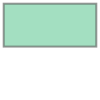

In [229]:
ignt5_bounds = bb2poly(M.get_bbounds(mbtfr))
ignt5_bounds
# %cd /opt/map/mapdata/mbtiles/Bugianen

In [214]:
areasdir = NBROOT + '/../data/areas/'
# Load French borders
fr = load_first_feature(areasdir + 'metropole.geojson')
# France metropolitaine is the biggest french territory
metro = biggest_poly(fr)

In [221]:
# a more precise datasource (but bigger): https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/france-shapefile

!ogr2ogr -t_srs EPSG:4326 -clipdst 6.855466 45.828796 7.207031 45.951147 $areasdir/fr_1km_alps.geojson $areasdir/fr_1km.shp

In [213]:
ch = load_first_feature(areasdir + 'switzerland.geojson')

In [46]:
# We want switzerland to count like it's french (ie, we want the italian Bugianen map to at into it as well) so:
frch_holy = cascaded_union([metro, ch])
frch = Polygon(frch_holy.exterior.coords)
with open(areasdir + 'frch.geojson', 'w') as f: f.write(json.dumps(mapping(frch)))

/tmp/ipykernel_104251/3188095681.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  frch_holy = cascaded_union([metro, ch])


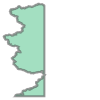

In [238]:
itwalps = shape(json.load(open(areasdir + 'it-alps-sanremo.geojson')))
display(itwalps)

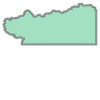

In [48]:

ignt5_bounds.intersection(itwalps)

# The "bad" IGN map

There is a part of IGN's italian side that's very blurry. We only need to remove that part.

In [ ]:
# this is the spot where map is really bad.
bad_bb = T.LngLatBbox(west=6.91041, north=45.67548, east=7.10811, south=45.58331)
ignt5_bad = bb2poly(bad_bb)

# The point (Lake "26333" north from Pointe de la Louie Blanche) is the left-most ad 2nd-north-most tile cut
#  a tile with jus "2550" is the top-left in bith z15 & 16

The point (Lake "26333" north from Pointe de la Louie Blanche) is the left-most ad 2nd-north-most tile cut
a tile with jus "2550" is the top-left in bith z15 & 16

According to [maptiler](https://www.maptiler.com/google-maps-coordinates-tile-bounds-projection/#16/7.12/45.44):
> TMS z16, 34026, 42135 <br>
> 6.910398, 45.671643
> 6.915896, 45.675484

> 17013 21067 <br>
> 6.910398, 45.667807
> 6.921385, 45.675484

What's tricky is that javascript and python differ on the left boundary at 4th decimal:
 6.910398 vs 6.910400 -- which is tricky given the use of flooring to convert with tile numbers.

tile center ~ 6.913 45.672

In [ ]:
print('',
    M.tms2bbox(16, x=34026, y=42135),'\n',
    M.tms2bbox(15, x=17013, y=21067))

 Bbox(left=6.910400390625004, bottom=45.67164385226548, right=6.9158935546875036, top=45.67548217560646) 
 Bbox(left=6.910400390625004, bottom=45.66780526567162, right=6.9213867187500036, top=45.67548217560646)


In [ ]:
(34025, (34025 * 360 / 2**16) - 180,
34026, (34026 * 360 / 2**16) - 180,
34027)

(34025, 6.9049072265625, 34026, 6.910400390625, 34027)

In [ ]:
(6.9049072265625 + 180) / 360 * 65536,\
(6.9049072265625 / 360 + 0.5) * 65536,\
(6.910400390625 + 180) / 360 * 65536

(34025.0, 34025.0, 34026.0)

In [ ]:
(6.9104 + 180) / 360 * 65536

34025.999928888894

In [ ]:
(
M.lnglat2tms(z=16, lng=6.9104, lat=45.67548),
M.lnglat2tms(z=16, lng=6.91041, lat=45.672),
M.lnglat2tms(z=16, lng=6.913, lat=45.672),
T.tile(6.9104, 45.672, 16),
T.tile(6.91041, 45.672, 16),
T.tile(6.913, 45.672, 16),
M.lnglat2tms(z=15, lng=6.9104, lat=45.672),
M.lnglat2tms(z=15, lng=6.91041, lat=45.672),
M.lnglat2tms(z=15, lng=6.913, lat=45.672),
T.tile(6.9104, 45.672, 15),
T.tile(6.91041, 45.672, 15),
T.tile(6.913, 45.672, 15)
)

((16, 34025.999928888894, 42135),
 (16, 34026.001749333336, 42135),
 (16, 34026.473244444445, 42135),
 Tile(x=34025, y=23400, z=16),
 Tile(x=34026, y=23400, z=16),
 Tile(x=34026, y=23400, z=16),
 (15, 17012.999964444447, 21067),
 (15, 17013.000874666668, 21067),
 (15, 17013.236622222223, 21067),
 Tile(x=17012, y=11700, z=15),
 Tile(x=17013, y=11700, z=15),
 Tile(x=17013, y=11700, z=15))

In [ ]:
def sh2geojson(sh, path):
    if not path.endswith('.geojson'):
        path += '.geojson'
    with open(path, 'w') as f:
        f.write(json.dumps(shapely.geometry.mapping(sh)))

In [ ]:
!gdalwarp -cutline frit5/ignt5_notbad.geojson -crop_to_cutline\
    -oo ZOOM_LEVEL=13 \
    $mbtfr notbad.mbtiles -overwrite

In [ ]:
!gdalwarp\
    -oo ZOOM_LEVEL=13 \
    "$mbtit" frit5/notbad.mbtiles  frit5/merged13.mbtiles -overwrite

In [131]:
# gpxsee $mbtfrclean

## Common to z15/z16

In [ ]:
!gdalwarp -cutline frit5/ignt5_bad.geojson -crop_to_cutline\
    -wo CUTLINE_ALL_TOUCHED=TRUE \
    -oo ZOOM_LEVEL=13 \
    $mbtfr bad.mbtiles

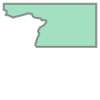

In [231]:
to_delete = ignt5_bad.intersection(ignt5_bounds).intersection(itwalps)
to_delete_geo = 'frit5/ignt5_bad.geojson'
sh2geojson(to_delete, to_delete_geo)
display(to_delete)

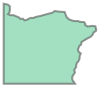

In [240]:
# This is used below to "mask" ign map before "overwriting" Bugianen
#to_keep = ignt5_bad - to_delete  # could be just:
to_keep = ignt5_bad.intersection(fr)
to_keep_geo = 'frit5/ignt5_keep.geojson'
sh2geojson(to_keep, to_keep_geo)
display(to_keep)

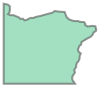

In [241]:
display(ignt5_bad - to_delete)

### z15 only

In [247]:
# crop italy to bbox
itcrop = 'frit5/itcrop.mbtiles'
!rm $itcrop
M.cut_to_lnglat(mbtitall, itcrop, bad_bb, zmin=15, zmax=16)

rm: cannot remove 'frit5/itcrop.mbtiles': No such file or directory
15 17013 <> 17030 21056 <> 21067
z 15 : 160
16 34026 <> 34061 42112 <> 42135
z 16 : 640
LngLatBbox(west=6.679687499999985, south=45.58328975600631, east=7.3828125000000036, north=45.9511496866914)


In [248]:
# crop fr to bbox
justbadclean = 'frit5/frjustbadclean.mbtiles'
!rm $justbadclean
M.cut_to_lnglat(mbtfrclean, justbadclean, bad_bb, zmin=15, zmax=16)

rm: cannot remove 'frit5/frjustbadclean.mbtiles': No such file or directory
15 17013 <> 17030 21056 <> 21067
z 15 : 155
16 34026 <> 34061 42112 <> 42135
z 16 : 638
LngLatBbox(west=5.976562500000004, south=45.58328975600631, east=7.130126953125003, north=46.43785689502421)


In [259]:
# crop france to the border
!gdalwarp -cutline $to_keep_geo -crop_to_cutline\
    "$justbadclean" frit5/notbad.vrt -overwrite

Using band 4 of source image as alpha.
Creating output file that is 4245P x 5244L.
Processing frit5/frjustbadclean.mbtiles [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [256]:
!rm frit5/merged15.mbtiles
!gdalwarp "$itcrop" frit5/notbad.vrt frit5/merged15.mbtiles \
    -oo ZOOM_LEVEL=15 \
    -co TILE_FORMAT=JPEG -co QUALITY=99

Warning 6: driver VRT does not support open option ZOOM_LEVEL
Creating output file that is 4608P x 3072L.
Using band 4 of destination image as alpha.
Processing frit5/itcrop.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing frit5/notbad.vrt [2/2] : 0Using band 4 of source image as alpha.
ERROR 10: Pointer 'hDS' is NULL in 'OGR_DS_ExecuteSQL'.

...10...20...30...40...50...60...70...80...90...100 - done.


In [263]:
# merge cropped france with cropped italy (takes ~3 minutes)
!rm frit5/merged16.mbtiles
!gdalwarp "$itcrop" frit5/notbad.vrt frit5/merged16.mbtiles \
    -oo ZOOM_LEVEL=16 \
    -co TILE_FORMAT=JPEG -co QUALITY=99

rm: cannot remove 'frit5/merged16.mbtiles': No such file or directory
Warning 6: driver VRT does not support open option ZOOM_LEVEL
Creating output file that is 9216P x 6144L.
Using band 4 of destination image as alpha.
Processing frit5/itcrop.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing frit5/notbad.vrt [2/2] : 0Using band 4 of source image as alpha.
ERROR 10: Pointer 'hDS' is NULL in 'OGR_DS_ExecuteSQL'.

...10...20...30...40...50...60...70...80...90...100 - done.


In [261]:
# somhow DRY version does not produce lower zoom
# !rm frit5/merged1516.mbtiles
# !gdalwarp "$itcrop" frit5/notbad.vrt frit5/merged1516.mbtiles \
#     -co MINZOOM=15 -co MAXZOOM=16 \
#     -co TILE_FORMAT=JPEG -co QUALITY=99

Creating output file that is 9216P x 6144L.
Using band 4 of destination image as alpha.
Processing frit5/itcrop.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing frit5/notbad.vrt [2/2] : 0Using band 4 of source image as alpha.
ERROR 10: Pointer 'hDS' is NULL in 'OGR_DS_ExecuteSQL'.

...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
# gdalwarp care more about lat/lng that mbtiles boundaries, so we need to discard the borders
#M.discard_bbox_borders('frit5/merged15.mbtiles', 'frit5/merged15.mbtiles')  # buggy
# merged15clean, stats = MP.clean_missing_data('frit5/merged15.mbtiles', w=0.1, T=255)
# merged15clean, stats

Deleted 0. Status: 0 / 168
Deleted 23. Status: done!


('frit5/clean_1673210971merged15.mbtiles.bkp',
 defaultdict(int, {'': 145, 'partial': 15, 'black&white': 8}))

In [ ]:
# M.apply_to_tiles('frit5/merged15.mbtiles', 'frit5/tmpborder15.mbtiles', fun=add_border)

cp frit5/merged15.mbtiles frit5/tmpborder15.mbtiles
<<>> frit5/merged15 : zoom = 15 15 ; n = 168 ; format = jpg ; bounds = 5.62500000000000355,45.5830194382466658,7.73197174072264026,46.5589783389018734
Changed 168 tiles


In [ ]:
!gpxsee $merged15clean

QSocketNotifier: Can only be used with threads started with QThread
QZip: not a zip file!
/home/me/.local/share/gpxsee/DEM/N45E006.hgt: No such file or directory


   %history -g -f ipython_history.py

## Merge levels

In [264]:
finalpath = f'frit5/{finalname}.mbtiles'
#!cp $mbtfrclean frit5/alps5-MontBlanc-Chambery-Evian.mbtiles
mbt_merge(
    mbtitall,
    mbtfrclean,
    'frit5/merged15.mbtiles',
    'frit5/merged16.mbtiles',
    dest=finalpath,
    name=finalname,
    description='Mont-Blanc area, merged from IGN and Bugianen.'
)

Deduplicating frit5/alps5-MontBlanc-Chambery-Evian.mbtiles....
<< frit5/Bugianen 2205 Monte Bianco : zoom = 12 16 ; n = 13981 ; bounds = 6.67969,45.58329,7.38281,45.95115 ; format = jpg
>> frit5/alps5-MontBlanc-Chambery-Evian : zoom = 9 16 ; n = 64787 ; bounds = 5.62500,45.58300,7.73200,46.55900 ; format = jpg
<< frit5/clean_1673208500IGNt5-MontBlanc-Chambery-Evian : zoom = 9 16 ; n = 55378 ; bounds = 5.97656,45.58329,7.13013,46.43786 ; format = jpg
>> frit5/alps5-MontBlanc-Chambery-Evian : zoom = 9 16 ; n = 64787 ; bounds = 5.62500,45.58300,7.73200,46.55900 ; format = jpg
<< frit5/merged15 : zoom = 15 15 ; n = 160 ; format = jpg ; bounds = 6.91040039062500355,45.5832897560063088,7.10815429687500089,45.6754821756064686
>> frit5/alps5-MontBlanc-Chambery-Evian : zoom = 9 16 ; n = 64787 ; bounds = 5.62500,45.58300,7.73200,46.55900 ; format = jpg
<< frit5/merged16 : zoom = 16 16 ; n = 640 ; format = jpg ; bounds = 6.91040039062500355,45.5832897560063088,7.10815429687500089,45.6754821756064

In [ ]:
# for zoom 9-14 , take $mbtfrclean and write over Bugianen

# for z15+, bugianen < mbtfrclean < badmerged
# so overall sequence  bugianen < mbtfrclean < badmerged16 < badmerged15

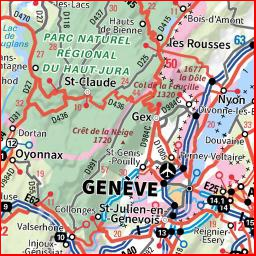

In [ ]:
z, x, y, img = next(M.get_all_tiles(mbtfrclean))
display(Image(G.jpeg_wrap(lambda imd: G.fill_border(imd, width=1))(img)))

In [89]:
!rm frit5/tmpborder13.mbtiles

def add_border(zoom_level, tile_column, tile_row, tile_data):
    return G.jpeg_wrap(lambda imd: G.fill_border(imd, width=1))(tile_data)
M.apply_to_tiles(mbtfrclean, 'frit5/tmpborder13.mbtiles', fun=add_border, zooms=[13,14,15])

cp frit5/clean_1672011103IGNt5-MontBlanc-Chambery-Evian.mbtiles frit5/tmpborder13.mbtiles
<<>> frit5/clean_1672011103IGNt5-MontBlanc-Chambery-Evian : zoom = 9 16 ; n = 59900 ; bounds = 5.625,45.583,7.732,46.559 ; format = jpg
Changed 15379 tiles


In [91]:
M.apply_to_tiles( 'frit5/tmpborder13.mbtiles', 'frit5/tmpborder13.mbtiles', fun=add_border, zooms=[9,10,11,12])

<<>> frit5/tmpborder13 : zoom = 9 16 ; n = 59900 ; bounds = 5.625,45.583,7.732,46.559 ; format = jpg
Changed 267 tiles


In [94]:
imd = M.lnglat2tile(mbtfrclean, z=13, lng=7.2, lat=46)

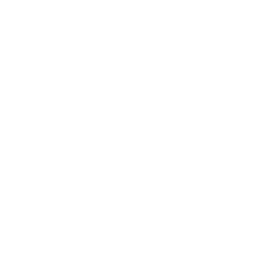

In [95]:
display(Image(imd))

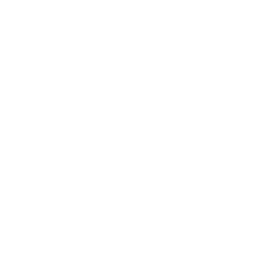

1651 JPEG RGB clrs 1 [(65536, (255, 255, 255))] black 0|0.0% white 65536|100.0% ; border-bw 0.0% 100.0% ; seed: (0, 0)


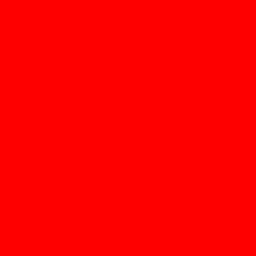

In [100]:
def info(imd, disp=True):
    PIXELS = 256**2
    global im, rgb, clrs
    assert(imd)
    if disp: display(Image(imd))
    im = Img.open(io.BytesIO(imd))
    rgb = G.to_numpy(im)
    clrs = im.getcolors(PIXELS)  # prevent getcolors returning None if too many colors :-O
    clrinfo = clrs if len(clrs) < 15 else f'[{clrs[0]}...{clrs[-1]}]'
    nb, nw = G.nblackwhite(rgb)
    nbb, nbw = G.bw_border_ratio(rgb)
    return print(len(imd), im.format, im.mode, 'clrs', len(clrs), clrinfo,
        f'black {nb}|{nb/PIXELS:.1%} white {nw}|{nw/PIXELS:.1%} ; border-bw {nbb:.1%} {nbw:.1%} '
        '; seed:', G.has_many_contiguous(rgb))


info(imd)
rgb[G.np_equal(rgb, G.NP_WHITE)] = np.array((255, 0, 0))
Img.fromarray(rgb)

In [101]:
MP.classify_tile(imd, 0.3)

('white', None, None)

In [133]:
import sqlite3
db = sqlite3.connect('frit5/justbadcleanfr16.mbtiles')
dbc = db.cursor()


In [138]:
M.tms2bbox(16, x=34025, y=42112)

Bbox(left=6.904907226562508, bottom=45.58328975600631, right=6.910400390625008, top=45.58713413436409)

In [141]:
z, x1w, x2e, y1s, y2n = byz[0]

bbsw = M.tms2bbox(16, x=x1w, y=y1s)
bbne = M.tms2bbox(16, x=x2e, y=y2n)

bbsw, bbne, \
bbsw.left, bbsw.bottom, bbne.right, bbne.top

(Bbox(left=6.904907226562508, bottom=45.58328975600631, right=6.910400390625008, top=45.58713413436409),
 Bbox(left=7.069702148437512, bottom=45.67164385226548, right=7.0751953125000115, top=45.67548217560646),
 6.904907226562508,
 45.58328975600631,
 7.0751953125000115,
 45.67548217560646)

In [145]:
M.real_bounds('frit5/justbadcleanfr16.mbtiles')

LngLatBbox(west=6.904907226562508, south=45.58328975600631, east=7.0751953125000115, north=45.67548217560646)

In [146]:
M.real_bounds('frit5/Bugianen 2205 Monte Bianco.mbtiles')

LngLatBbox(west=6.679687499999985, south=45.58328975600631, east=7.3828125000000036, north=45.9511496866914)

In [147]:
mbt_info(mbtitall)

'zoom = 12 16 ; n = 13981 ; bounds = 6.680,45.583,7.383,45.951 ; format = jpg'

In [13]:
finalpath = f'frit5/{finalname}.mbtiles'

M.update_mbt_meta(finalpath, name=finalname)

{'name': 'alps5-Mont-Blanc-Leman-Cervino-Cogne', 'type': 'baselayer'}


In [ ]:
M.cut_to_lnglat(T.LngLatBbox(w=6, south=45.644, east=9, north=47))

In [ ]:
# !rm -f $workdir/merged14.mbtiles
# ds = gdal.Warp(
#     mrg14, [mbtfr14, pjoin(workdir,'it14.vrt')],
#     options=gdal.WarpOptions(
#         creationOptions=dict(TILE_FORMAT='JPEG', QUALITY=99)))


# Temp Fixes

In [ ]:
# MY.tile_pyramid('frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles', )

In [50]:
M.cut_to_lnglat('../../mapdata/mbtiles/mch.mbtiles', 'frit5/chcut.mbtiles', GY.alps5)

9 16 16
9 264 <> 266 329 <> 330
z 9 : added 6
10 528 <> 533 658 <> 661
z 10 : added 24
11 1058 <> 1067 1317 <> 1323
z 11 : added 70
12 2112 <> 2135 2632 <> 2647
z 12 : added 384
13 4232 <> 4271 5268 <> 5295
z 13 : added 1120
14 8464 <> 8543 10536 <> 10591
z 14 : added 4435
15 16928 <> 17087 21072 <> 21183
z 15 : added 13429
16 33856 <> 34175 42169 <> 42367
z 16 : added 42473
Meta update {'bounds': '5.625,45.58329,7.73438,46.55886',
 'center': '6.67969,46.07108,9',
 'type': 'baselayer'}


In [47]:
!rm frit5/fritnocorner.mbtiles
M.remove_lnglat('frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles',
                'frit5/fritnocorner.mbtiles',
                GY.LLBb(7.03, 40, 8, 45.644),
                zmin=14)

cp frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles frit5/fritnocorner.mbtiles
<<>> frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne : zoom = 9 16 ; n = 64787 ; bounds = 5.625,45.58329,7.03125,46.55886 ; center = 6.32813,46.07108,9 ; format = jpg ; name = alps5-Mont-Blanc-Leman-Cervino-Cogne
14 16 16
z 14 : removed 36
z 15 : removed 129
z 16 : removed 257
Meta update {'bounds': '5.625,45.58329,7.73438,46.55886',
 'center': '6.67969,46.07108,9',
 'type': 'baselayer'}


In [48]:
# M.cut_to_lnglat('frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles', 'frit5/frittmp.mbtiles', GY.bbalps5._replace(east=7.031))

In [54]:
M.remove_tile_ll('frit5/chcut.mbtiles', 15, T.LngLat(6.82, 45.71))
M.remove_tile_ll('frit5/chcut.mbtiles', 15, T.LngLat(6.83, 45.71))
M.remove_tile_ll('frit5/chcut.mbtiles', 15, T.LngLat(6.82, 45.72))
M.remove_tile_ll('frit5/chcut.mbtiles', 15, T.LngLat(6.83, 45.72))

In [ ]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')

In [55]:
!rm -f finalpath
M.mbt_merge(
    mbtitcut,
    'frit5/fritnocorner.mbtiles',
    mbtbasemapclean,
    'frit5/chcut.mbtiles',
    dest=finalpath
)

cp frit5/itcutN.mbtiles frit5/newch.mbtiles
<<>> frit5/itcutN : zoom = 12 16 ; n = 25575 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen
<< frit5/fritnocorner : zoom = 9 16 ; n = 64365 ; bounds = 5.625,45.58329,7.73438,46.55886 ; center = 6.67969,46.07108,9 ; format = jpg ; name = alps5-Mont-Blanc-Leman-Cervino-Cogne
>> frit5/newch : zoom = 9 16 ; n = 75977 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen
<< frit5/basemap-clean : zoom = 9 12 ; n = 510 ; bounds = 5.625,45.58329,7.73438,46.55886 ; center = 6.67969,46.07108,9 ; format = jpg ; name = IGN France baselayer z9-12
>> frit5/newch : zoom = 9 16 ; n = 76179 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen
<< frit5/chcut : zoom = 9 16 ; n = 61937 ; bounds = 4.21875,44.37000,13.35938,48.45835 ; format = jpeg ; name = SwissTopo mix-scale
>> frit5/newch : 

In [56]:
M.get_meta(finalpath)

{'bounds': '5.625,45.58329,7.73438,46.55886',
 'name': 'frit5/newch',
 'type': 'baselayer',
 'version': '1.1',
 'description': 'Merge of the following files:\n* Bugianen : Bugianen 2205 Cervino : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.\nLicenza Creative Commons CC BY-NC-SA 3.0 IT.\nPer la legenda e l\'origine dei dati visita <a href="https://tartamillo.wordpress.com/sorbetto/">tartamillo.wordpress.com/sorbetto/</a>\n* alps5-Mont-Blanc-Leman-Cervino-Cogne : IGNt5-MontBlanc-Chambery-Evian created on 2021-02-20 01:52:46 by MOBAC\n* IGN France baselayer z9-12 : IGN France baselayer z9-12\n* SwissTopo mix-scale : Switzerland SwissTopo National Map, zoom 9-16. https://map.geo.admin.ch\nUnlike the website, this is a downscaled version when possible (1 zoom level up for each layer).\n',
 'format': 'jpg',
 'attribution': '<a href="https://tartamillo.wordpress.com/sorbetto/">© tartamillo.wordpress.com</a>. Source data: OpenStreetMap contributors, Regione Piemonte, Reg

In [9]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')

In [73]:
finalname = mbtnames_merged[fritN]
description = finalname[6:] + ''' area, fusion de cartes IGN et Bugianen:
* Swisstopo (2021). 
* IGN Top 25 et top 100 (2021)
* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.
Per la legenda e l'origine dei dati visita '''\
'<a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.'
attribution = '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> '\
    '/ © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a> '\
    '/ © <a href="https://www.swisstopo.admin.ch/fr/home/meta/conditions-generales/geodonnees/ogd.html">Swisstopo OGD</a>'
M.update_mbt_meta(finalpath, name=finalname, desc=description, attrib=attribution)

In [62]:
!mv frit5/newch.mbtiles '../../mapdata/mbtiles/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles'

In [84]:
for i in(1,3,4,5):
    print(mbt_info(f'../../mapdata/mbtiles/{mbtnames_merged[i]}.mbtiles'))

zoom = 9 16 ; n = 92072 * 30 kb/tile ; bounds = 6.32812,43.58039,8.4375,44.59047 ; center = 7.38281,44.08543,9 ; format = jpg ; name = alps1-Mercantour-Ubaye-Cuneese
zoom = 9 16 ; n = 68648 * 37 kb/tile ; bounds = 4.92188,44.58656,7.73438,45.08904 ; center = 6.32813,44.83780,9 ; format = jpg ; name = alps3-Vercors-Ecrins-Queyras-Cozie
zoom = 9 16 ; n = 64814 * 45 kb/tile ; bounds = 5.625,45.08904,8.4375,45.58329 ; center = 7.03125,45.33616,9 ; format = jpg ; name = alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso
zoom = 9 16 ; n = 109296 * 25 kb/tile ; bounds = 5.625,45.58329,7.73438,46.55886 ; center = 6.67969,46.07108,9 ; format = jpg ; name = alps5-Mont-Blanc-Leman-Cervino-Cogne


In [5]:
mbt_info('../../mapdata/mbtiles/Bugianen.mbtiles')

'zoom = 12 16 ; n = 152742 * 23 kb/tile q = 80 ; bounds = 7.73437,45.58329,8.78906,46.49839 ; center = 8.26172,46.04084,12 ; format = jpg ; name = Bugianen'

In [4]:
source = 'frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles'
dest5 = '../../mapdata/mbtiles/alps5-Mont-Blanc-Chambéry-Leman.mbtiles'
dest6 = '../../mapdata/mbtiles/alps6-Aoste-Martigny-Gruyère.mbtiles'

M.cut_to_lnglat(source, dest5, GY.bbalps5z10, zmin=10)
M.cut_to_lnglat(source, dest6, GY.bbalps6, zmin=10)

10 16 16
z 10: +12 tiles: 529<x<531 658<y<661
z 11: +48 tiles: 1058<x<1063 1316<y<1323
z 12: +192 tiles: 2116<x<2127 2632<y<2647
z 13: +768 tiles: 4232<x<4255 5264<y<5295
z 14: +3072 tiles: 8464<x<8511 10528<y<10591
z 15: +12288 tiles: 16928<x<17023 21056<y<21183
z 16: +49139 tiles: 33856<x<34047 42112<y<42367
Fallback `center` to first tile:  9 264 329 5.976562500000014 45.82826019070733
Meta update {'bounds': '5.97656,45.58329,7.03125,46.55886',
 'center': '5.97656,45.82826,9',
 'maxzoom': 16,
 'minzoom': 10,
 'type': 'baselayer'}
10 16 16
z 10: +8 tiles: 532<x<533 658<y<661
z 11: +32 tiles: 1064<x<1067 1316<y<1323
z 12: +128 tiles: 2128<x<2135 2632<y<2647
z 13: +512 tiles: 4256<x<4271 5264<y<5295
z 14: +2048 tiles: 8512<x<8543 10528<y<10591
z 15: +8192 tiles: 17024<x<17087 21056<y<21183
z 16: +32767 tiles: 34048<x<34175 42112<y<42367
Fallback `center` to first tile:  9 264 329 5.976562500000014 45.82826019070733
Meta update {'bounds': '7.03125,45.58329,7.73438,46.55886',
 'center': 

fritch5 completeness: good

one hole on the left: z9-12 start at west=5.625 but z13-16 at 5.977 (z10)


In [6]:
!gh release upload 202301 $dest5
!gh release upload 202301 $dest6

Successfully uploaded 1 asset to 202301
Successfully uploaded 1 asset to 202301


In [17]:
M.update_with(source='../../mapdata/mbtiles/alps-z612.mbtiles', dest=finalpath)
#mbtnames_merged[fritN])

Updated 252
